In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

## Heat Plotter Function (with ability to select time and x ranges)

Copied from previous work; allows graph selection of time and x ranges:

In [49]:
def heat_plotter_advanced(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot):
    
    dt = t_max/len(U)
    t_min_index = int(t_min_plot / dt)
    #*#t_max_index = int(t_max_plot / dt)
    t_max_index = int(t_max_plot / dt) +1
    print('t_min_index:',t_min_index)
    print('t_max_index:',t_max_index)
    
    dx = L/len(U[0])
    x_min_index = int(x_min_plot / dx)
    x_max_index = int(x_max_plot / dx)
    print('x_min_index:',x_min_index)
    print('x_max_index:',x_max_index)

    # Create slice to analyze
    U_slice = U[t_min_index:t_max_index]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('x')  # Set x-axis label
    ax.set_ylabel('u(t,x)')  # Set y-axis label

    # Set the y-axis limits
    y_min = min([min(u) for u in U_slice]) - 0.5  # Find the minimum y-value in U with some buffer
    y_max = max([max(u) for u in U_slice]) + 0.5  # Find the maximum y-value in U with some buffer
    ax.set_ylim(y_min, y_max)

    # Set the x-axis limits
    ax.set_xlim(x_min_plot, x_max_plot)
    
    lines = []  # List to store line objects
    alpha_decay = .5  # Factor to reduce the alpha of previous lines

    plt.show()
    
    interval = len(U_slice)//steps
    
    for i in np.arange(0, len(U_slice), interval):
        # Update the alpha values of existing lines
        
        for line in lines:
            line.set_alpha(line.get_alpha() * alpha_decay)
    
        # Compute scaled x-axis values
        x_values = np.linspace(0, L, len(U_slice[i]))
        x_values_used = x_values[x_min_index:x_max_index+1]
        
        # Add new line
        new_line, = ax.plot(x_values_used,U_slice[i][x_min_index:x_max_index+1], color='red', alpha=1.0)  # Start with full opacity
        lines.append(new_line)  # Store the new line object
        #ax.set_title(f"Plot at time = {i/(len(U_slice)-1)}s")  # Update the title with the current step
        ax.set_title(f"Plot at time, t = {round(t_min_plot + i*dt,3)}s")
        
        
        # Handling plot display
        clear_output(wait=True)  # Clear the previous plot
        display(fig)  # Display the current figure

        time.sleep(0.25)  # Pause for half a second before the next update   

## Explicit Method

In [62]:
L = 3
t_max = 1

dx = .01
dt = .001

Nx = int(L/dx) + 1
Nt = int(t_max/dt)

x_grid = np.linspace(0,L,Nx)
t_grid = np.linspace(0,t_max,Nt)

U = []

u_t_x_0 = []

for x in x_grid:
    u_t_x_0.append(x * (x-1) * (x-3))
U.append(u_t_x_0)

In [63]:
for i in range(Nt):
    u_t_x = []
    
    u_line = U[-1]
    
    for j in range(1,Nx-1):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        u = -u_line[j] * (dt/(2*dx)) * (u_line[j+1] - u_line[j-1]) + u_line[j]
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,0)
    u_t_x.insert(len(u_line),0)

    # Now append the full solutions matrix
    U.append(u_t_x) 

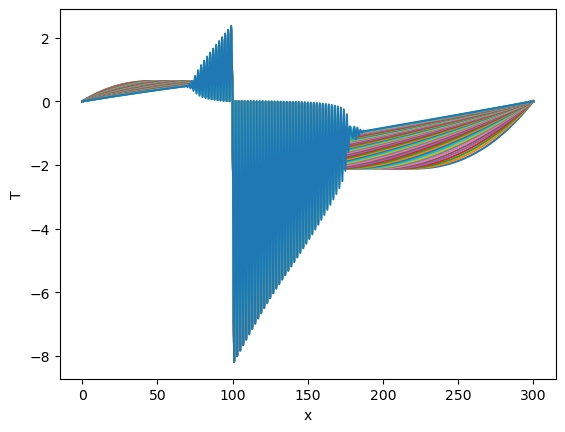

In [64]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in np.arange(0,len(U),20):
    plt.plot(U[i])
    plt.xlabel('x')
    plt.ylabel('T')
plt.show()

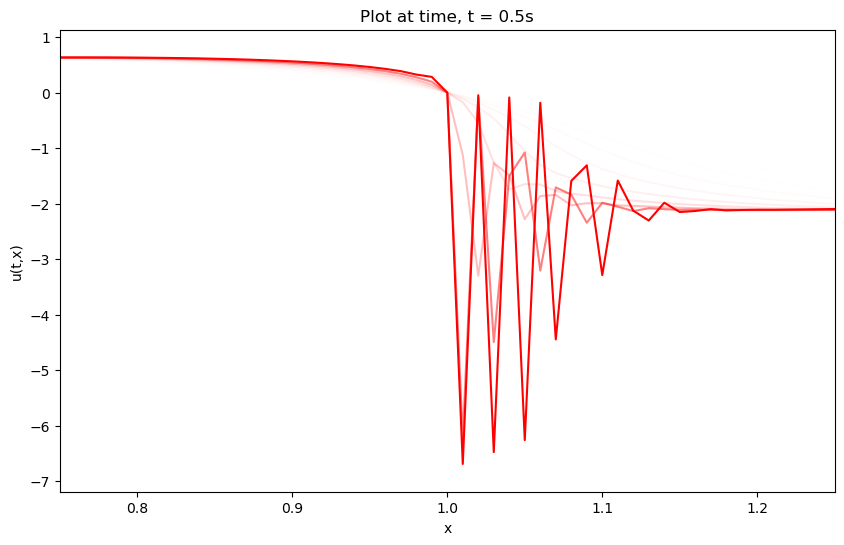

In [67]:
steps = 20
t_min_plot = 0             # default = 0
t_max_plot = .5      # default = len(U)
x_min_plot = .75             # default = 0
x_max_plot = 1.25          # default = L

heat_plotter_advanced(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot)

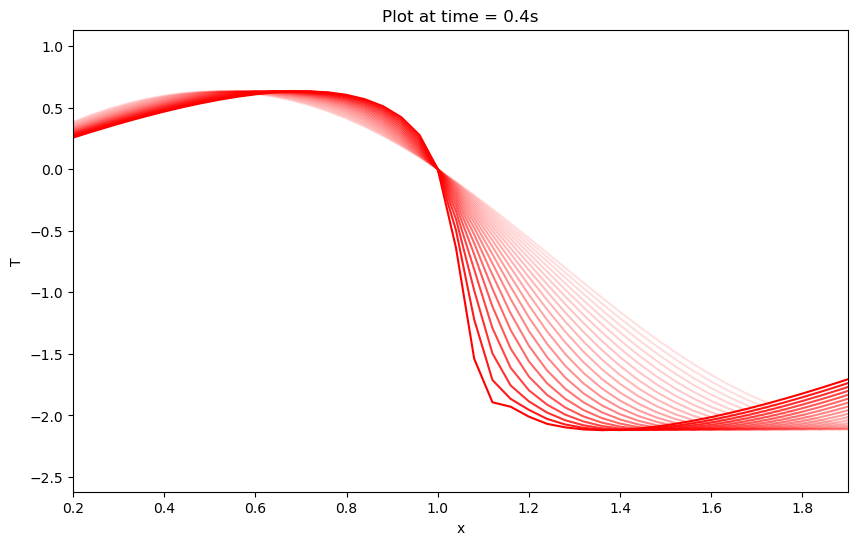

In [10]:
# heat_plotter_advanced(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot)
heat_plotter_advanced(U, L, t_max, 20, .1, .4, .2, 1.9)

## Sidebar: Node vs grid number 

Methods should be able to take either dx & dt or number of time and space nodes.  First the basic relationship and comparison should be explored.

In [70]:
# User defined givens:
L = 1 # Length of Rod
t_max = 1 # Length of time to analyze

x_grid_nodes = 5 # Desired number of x nodes to analyze
t_grid_nodes = 20 # Desired number of time steps to analyze

dx = .2 # Node width to analyze
dt = .05 # Time step to analyze

# Calculated Results

x_nodes = int(L/dx) + 1 # Should equal x_grid_nodes
t_nodes = int(t_max/dt) + 1 # Should equal t_grid_nodes

n_dx = L/x_grid_nodes
n_dt = t_max/t_grid_nodes

(x_grid_nodes == x_nodes -1),(t_grid_nodes == t_nodes - 1),((dx,dt) == (n_dx, n_dt))
 
#t_grid_slices,dx,dt,x_nodes,t_nodes,Ndx,Ndt

(True, True, True)

#### Option 1: Enter desired number of nodes

In [ ]:
# Length of Rod:
L = 3

# Length of time to analyze:
t_max = 1

# Desired number of x nodes to analyze, with outer nodes the boundary conditions
# use +1 to align with range
x_grid_nodes = 31

# Desired number of time steps to analyze
t_grid_nodes = 301

In [ ]:
# Calcs
dx = L/x_grid_nodes
dt = t_max/t_grid_nodes

x_grid = np.linspace(0,L,x_grid_nodes) # two boundary nodes at 0 & L, rest are inner nodes
t_grid = np.linspace(0,t_max,t_grid_nodes) # Need to change node here by +1 for proper t-intervals

In [ ]:
# Create solution data holder
U = []

# Input initial conditions (t = 0)
u_t_x_0 = []

for x in x_grid:
    u_t_x_0.append(f_u_0_x(x))

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U.append(u_t_x_0)
len(U[0]),U

In [ ]:
for i in range(len(t_grid)):
    u_t_x = []
    
    u_previous = U[-1]
    
    for j in range(1,len(x_grid)-1):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        #! - Note: can use classes or other methods to choose which function is used
        u = inviscid_bugers_explicit_function(u_previous,j,dt,dx)
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(i*dt))
    u_t_x.append(f_u_t_L(i*dt))
    print(u_t_x)

    # Now append the full solutions matrix
    U.append(u_t_x) 

In [ ]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in range(len(U)):
    plt.plot(U[i])
    plt.xlabel('x')
    plt.ylabel('T')
plt.show()

In [ ]:
t_min = 0
t_max = 3

t_total = len(U)
print('t_total:',t_total)
i_min = (t_min+t_total)//t_total
i_max = (t_min+t_total)//t_total

i_min, i_max

In [ ]:
len(U),U

In [ ]:
len(U)

In [ ]:
# Boundary Condition Functions (Direchelet - time domain)

def u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''    
    return t

def u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

# Initial Condition Functions

def u_0_x(x):
    '''
    Assigns the initial values for u (non-boundary points).
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return x * (x - 1) * (x - 3)

In [ ]:
# Assign length
L = 3
t_max = 5

# Grid spacing
dx = .1
dt = .1 # !-Note: For explicit needs to be less than dt**2/(2*D), implicit has no such restrictions for stability

# Number of dx nodes, including 0 node
Nx = int(L/dx) + 1

# Discretize x and t
x = np.arange(0,L+dx,dx)
t = np.arange(0,t_max+dt,dt)

# Create return array (n x m matrix)
n = len(x)
m = len(t)
T = np.zeros((m,n))

# Set boundary values
T[:,0] = u_t_0(0)
T[:,-1] = u_t_L(0)

# Derive the Lambda, as lambo
lambo = dt/(2*dx)

In [ ]:
# LHS = A: a tridiagnonal matrix
A = np.diag([1+2*lambo]*(Nx-2)) + np.diag([-lambo]*(Nx-3),1) + np.diag([-lambo]*(Nx-3),-1)

## Crank-Nicholson

In [ ]:
# Parameters
L = 1          # Length of the domain
N = 10           # Number of spatial points
dx = L / N        # Spatial step size
dt = 0.1         # Time step size
T = 2.0           # Total time
timesteps = int(T / dt)

# Initial condition: a sine wave
x = np.linspace(0, L, N)
u = np.sin(2 * np.pi * x / L)

# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(x, u, label='Initial condition')

def burgers_crank_nicolson(u):
    unew = np.copy(u)
    for n in range(timesteps):
        un = np.copy(unew)
        for i in range(1, N-1):
            # Nonlinear terms using averages
            term_n = 0.5 * un[i] * (un[i+1] - un[i-1])
            term_new = 0.5 * unew[i] * (unew[i+1] - unew[i-1])
            # Crank-Nicolson scheme
            unew[i] = un[i] - 0.5 * dt / dx * (term_n + term_new)
        # Periodic boundary conditions
        unew[0] = unew[-2]
        unew[-1] = unew[1]
        plt.plot(x, unew)
    return unew

# Run the simulation
u_final = burgers_crank_nicolson(u)

plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

## Appendices

Original "Simple" Heat Plotter Function

In [5]:
def heat_plotter(U, L, t_max, steps):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('x')  # Set x-axis label
    ax.set_ylabel('T')  # Set y-axis label

    # Set the y-axis limits
    y_min = min([min(u) for u in U]) - 0.5  # Find the minimum y-value in U with some buffer
    y_max = max([max(u) for u in U]) + 0.5  # Find the maximum y-value in U with some buffer
    ax.set_ylim(y_min, y_max)

    # Set the x-axis limits
    ax.set_xlim(0, L)
    
    lines = []  # List to store line objects
    alpha_decay = .9  # Factor to reduce the alpha of previous lines

    plt.show()

    for i in np.arange(0, len(U), len(U)//steps):
        # Update the alpha values of existing lines
        for line in lines:
            line.set_alpha(line.get_alpha() * alpha_decay)

        # Compute scaled x-axis values
        x_values = np.linspace(0, 2, len(U[i]))
        
        # Add new line
        new_line, = ax.plot(x_values,U[i], color='red', alpha=1.0)  # Start with full opacity
        lines.append(new_line)  # Store the new line object
        ax.set_title(f"Plot at time = {i/(len(U)-1)}s")  # Update the title with the current step

        # Handling plot display
        clear_output(wait=True)  # Clear the previous plot
        display(fig)  # Display the current figure

        time.sleep(0.25)  # Pause for half a second before the next update